In [1]:
import numpy as np
import pandas as pd
from statistics import stdev
import matplotlib.pyplot as plt
import math
from scipy import stats
pd.options.display.max_rows = 9999

In [4]:
files= [f'https://raw.githubusercontent.com/hmku/mwtc-2020/master/MWTC-platform-release/case1/DATA/201{i}.csv' for i in range(10)]
dfs = [pd.read_csv(file) for file in files]
dfs

[     Unnamed: 0  CONSUMPTION  AVG_PRICE
 0    2010-01-01     0.000000   0.000000
 1    2010-01-02     0.447285   2.000000
 2    2010-01-03    14.339777   2.000000
 3    2010-01-04    17.388527   2.000000
 4    2010-01-05    28.372350   2.000000
 5    2010-01-06    42.239128   2.000000
 6    2010-01-07    51.683224   2.000000
 7    2010-01-08    62.138573   2.000000
 8    2010-01-09    72.218965   2.000000
 9    2010-01-10    73.964033   2.000000
 10   2010-01-11    95.225155   2.000000
 11   2010-01-12   105.287283   2.000000
 12   2010-01-13   109.550969   2.000000
 13   2010-01-14   124.628878   2.000000
 14   2010-01-15   165.134694   2.000000
 15   2010-01-16   186.509623   2.000000
 16   2010-01-17   187.512084   2.000000
 17   2010-01-18   191.201534   2.000000
 18   2010-01-19   194.690197   2.000000
 19   2010-01-20   202.859792   2.000000
 20   2010-01-21   206.384068   2.000000
 21   2010-01-22   222.305606   2.000000
 22   2010-01-23   226.488839   2.000000
 23   2010-01-24

In [5]:
# helper function for plotting
def plot(df, *args, cs=False):
    if len(args) == 0:
        args = list(df.columns)
    dft = pd.DataFrame()
    for arg in args:
        dft[arg] = df[arg].cumsum() if cs else df[arg]
    dft.plot(figsize=(15, 10), y=list(args))

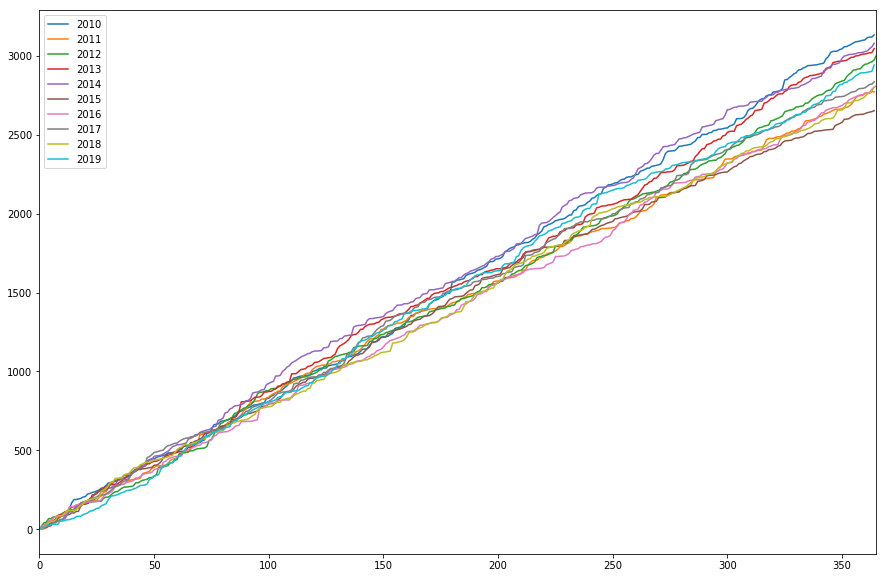

In [6]:
cons = pd.concat([df['CONSUMPTION'] for df in dfs], axis=1)
cons.columns = list(range(2010, 2020))
plot(cons)

In [7]:
dfs_filtered = []
for df in dfs:
    ch = df['AVG_PRICE'].diff()
    chs = ch.shift(-1)
    dfs_filtered.append(df.loc[df['AVG_PRICE'] <= 3.01][(ch != 0) | (chs != 0)])

dfs_filtered

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


[     Unnamed: 0  CONSUMPTION  AVG_PRICE
 0    2010-01-01     0.000000   0.000000
 1    2010-01-02     0.447285   2.000000
 159  2010-06-09  1284.081440   2.000000
 160  2010-06-10  1318.734240   2.540627
 161  2010-06-11  1326.127237   3.000000
 202  2010-07-22  1728.235906   3.000000
 203  2010-07-23  1758.608405   3.001503,
      Unnamed: 0  CONSUMPTION  AVG_PRICE
 0    2011-01-01     0.000000   0.000000
 1    2011-01-02    10.684759   2.000000
 158  2011-06-08  1308.201090   2.000000
 159  2011-06-09  1316.810398   2.709962
 160  2011-06-10  1323.333568   3.000000
 225  2011-08-14  1762.773608   3.000000
 226  2011-08-15  1773.751202   3.001928,
      Unnamed: 0  CONSUMPTION  AVG_PRICE
 0    2012-01-01     0.000000   0.000000
 1    2012-01-02    22.931186   2.000000
 162  2012-06-11  1316.306546   2.000000
 163  2012-06-12  1323.790684   2.807337
 164  2012-06-13  1330.994891   3.000000
 224  2012-08-12  1753.049406   3.000000
 225  2012-08-13  1795.281139   3.002647,
      Unnamed

In [8]:
# helper function to calculate specific spot in interval where coal consumption ends given amount of consumption
# over the interval and average price over the interval
def coal_point(avg_price, start_cons, end_cons):
    total_cons = end_cons - start_cons
    total = avg_price * total_cons
    peaker_price = 3.001
    cons = 0
    while total - peaker_price >= 0:
        total -= peaker_price
        peaker_price += 0.001
        cons += 1
    return start_cons + (peaker_price * (total_cons - cons) - total) / (peaker_price - 3)

In [9]:
# when does chicago run out of natural gas / coal?
gas_rows = [df.loc[(df['AVG_PRICE'] > 2)].iloc[0] for df in dfs]
gas = [(df.iloc[row.name]['AVG_PRICE'] - 2) * df.iloc[row.name - 1]['CONSUMPTION']
       + (3 - df.iloc[row.name]['AVG_PRICE']) * df.iloc[row.name]['CONSUMPTION']
       for df, row in zip(dfs, gas_rows)]
coal_rows = [df.loc[(df['AVG_PRICE'] > 3)].iloc[0] for df in dfs]
coal = [coal_point(df.iloc[row.name]['AVG_PRICE'], df.iloc[row.name - 1]['CONSUMPTION'], df.iloc[row.name]['CONSUMPTION'])
       for df, row in zip(dfs, coal_rows)]
dfgc = pd.DataFrame(zip(gas, coal), index=range(2010, 2020), columns=['gas', 'coal'])
dfgc['gas_diff'] = dfgc['gas'].diff()
dfgc['coal_diff'] = dfgc['coal'].diff()
dfgc['gas_norm'] = dfgc['gas'].apply(lambda x: (x - dfgc['gas'].mean()) / dfgc['gas'].std())
dfgc['coal_norm'] = dfgc['coal'].apply(lambda x: (x - dfgc['coal'].mean()) / dfgc['coal'].std())
dfgc

,gas,coal,gas_diff,coal_diff,gas_norm,coal_norm
2010,1300.000000,1742.135478,NaN,NaN,-1.436696,-1.517734
2011,1310.698112,1766.826889,10.698112,24.691411,-1.140412,-1.064166
2012,1317.748466,1772.119590,7.050355,5.292701,-0.945153,-0.966942
2013,1332.081059,1797.426883,14.332593,25.307293,-0.548212,-0.502060
2014,1343.136976,1814.115749,11.055917,16.688866,-0.242019,-0.195494
2015,1368.707619,1846.508650,25.570643,32.392900,0.466159,0.399546
2016,1372.722713,1856.014096,4.015094,9.505446,0.577357,0.574156
2017,1379.370680,1863.601351,6.647967,7.587255,0.761472,0.713530
2018,1388.729425,1884.549501,9.358745,20.948150,1.020662,1.098336
2019,1405.562093,1904.282832,16.832668,19.733331,1.486843,1.460827


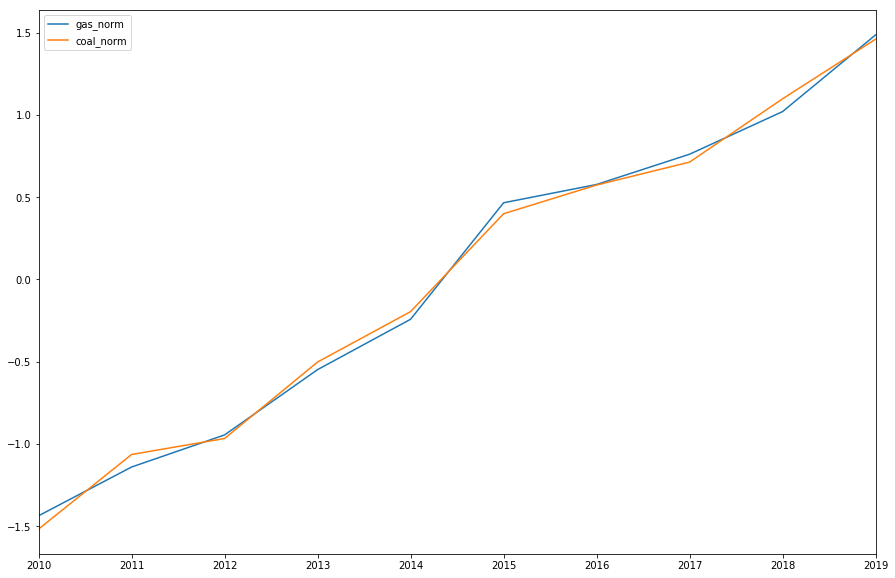

In [10]:
plot(dfgc, 'gas_norm', 'coal_norm')

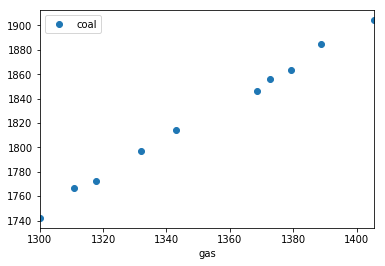

In [14]:
dfgc.plot(x='gas', y='coal', style='o')

In [12]:
m, b, r, p, se = stats.linregress(dfgc['gas'].values[1:], dfgc['coal'].values[1:])
print(m, b, r, p, se)

1.475141438459995 -168.77216070111626 0.998431453657305 5.024759869220758e-10 0.03126509080315385


In [13]:
print(dfgc['gas_diff'].mean())
print(dfgc['coal_diff'].mean())

11.729121446426436
18.016372633113733
